In [1]:
path=''
file=path+"data.xlsx"

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import random

%matplotlib inline
import matplotlib.pyplot as plt

# Graphs
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb  # For displaying graphs in Jupyter
import pyAgrum.lib.bn2graph as bnPlot  # To plot Bayesian Networks
import pyAgrum.lib.dynamicBN as gdyn  # For Dynamic Bayesian Networks
import pyAgrum.lib.image as gimg  # For exporting images of graphs
from IPython.display import Image  # To display the exported images

# Classification
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, log_loss, recall_score

# For Visualization
from sklearn.manifold import TSNE
import seaborn as sns

# Stats
from scipy.stats import zscore

# Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Trees
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.tree import export_graphviz
import graphviz

In [4]:
# Set Colors
one=np.array([86, 173, 175])/255 # Turq
two=np.array([57, 91, 142])/255 # Blue - dark
three=np.array([240, 128, 128])/255 # coral
four=np.array([255, 87, 51])/255 # Orange
five=np.array([69, 105, 144])/255 # blue opaco
colors=[one,five,three,four]


# 1. Data Exploration
1. Target: diagnosis
2. Key Features:
*   Creatinine is a protein that is often used as an indicator of kidney function.
*   YVLE1 is lymphatic vessel endothelial hyaluronan receptor 1, a protein that may play a role in tumor metastasis
*   REG1B is a protein that may be associated with pancreas regeneration
*   TFF1 is trefoil factor 1, which may be related to regeneration and repair of the urinary tract
*   Age and sex, both included in the dataset, may also play a role in who gets pancreatic cancer.

Others
*   benign_sample_diagnosis: Only present in category 2, so maybe not useful


In [5]:
# Read data
df_ini= pd.read_excel(file)
headers=list(df_ini.columns )
df_ini.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


## 1.1. Know which variables do I have, how many unique values, which kind of values, which type...

In [6]:
def f_descriptive(df_ini):
    # Create a table to understand my dataset
    df_des = df_ini.dtypes.reset_index()
    df_des.columns = ['Variable', 'Data Type']

    # Know the number of unique values for each variable
    df_des['Unique'] = df_ini.nunique().values

    # Examples
    df_des['Examples'] = df_des['Variable'].apply(lambda label: df_ini[label].unique()[:3])

    # Some statistics
    df_des['Min'] = df_des['Variable'].apply(lambda label: df_ini[label].min() if pd.api.types.is_numeric_dtype(df_ini[label]) else None)
    df_des['Max'] = df_des['Variable'].apply(lambda label: df_ini[label].max() if pd.api.types.is_numeric_dtype(df_ini[label]) else None)
    df_des['Avg'] = df_des['Variable'].apply(lambda label: df_ini[label].mean() if pd.api.types.is_numeric_dtype(df_ini[label]) else None)
    df_des['Std'] = df_des['Variable'].apply(lambda label: df_ini[label].std() if pd.api.types.is_numeric_dtype(df_ini[label]) else None)

    # % null values
    df_des['Null%'] = df_des['Variable'].apply(lambda label: int(df_ini[label].isnull().mean() * 100))

    # Display the modified DataFrame
    return df_des

df_des=f_descriptive(df_ini)
df_des

,Variable,Data Type,Unique,Examples,Min,Max,Avg,Std,Null%
0,sample_id,object,590,"[S1, S10, S100]",NaN,NaN,NaN,NaN,0
1,patient_cohort,object,2,"[Cohort1, Cohort2]",NaN,NaN,NaN,NaN,0
2,sample_origin,object,4,"[BPTB, LIV, ESP]",NaN,NaN,NaN,NaN,0
3,age,int64,63,"[33, 81, 51]",26.000000,89.000000,59.079661,13.109520,0
4,sex,object,2,"[F, M]",NaN,NaN,NaN,NaN,0
5,diagnosis,int64,3,"[1, 2, 3]",1.000000,3.000000,2.027119,0.804873,0
6,stage,object,8,"[nan, I, IA]",NaN,NaN,NaN,NaN,66
7,benign_sample_diagnosis,object,47,"[nan, Abdominal Pain, Biliary Stricture (Secon...",NaN,NaN,NaN,NaN,64
8,plasma_CA19_9,float64,266,"[11.7, nan, 7.0]",0.000000,31000.000000,654.002944,2430.317642,40
9,creatinine,float64,198,"[1.83222, 0.97266, 0.78039]",0.056550,4.116840,0.855383,0.639028,0


* We can see that all our key features [Creatinine, YVLE1, REG1B, and TFF1] are given for all the tests of the dataset.

* REG1A and PLASMA_CA19_9 are not always given. However it has been proved that they can help in the Early Detection of Pancreatic Adenocarcinoma. Then, it could be highly interesting to explore them https://pubmed.ncbi.nlm.nih.gov/26240291/

## 1.2. Quick research about variables:
Typical values for
* plasma_CA19_9: 0 - 37
* creatinine: 0.6 - 1.1 /0.7 - 1.3
* Higher levels of LYVE1, REG1B, TFF1, and REG1A could lead to cancer

## 1.3. Target Distribution
Our target is "diagnosis" so let's verify:
1. Number of unique values
2. If it exists for all our dataset -> If target is missing, then maybe we should delete it as we cannot train/measure the model
Because of the previous analysis, we know "diagnosis" is always given, so no extra action is needed

In [7]:
def fv_hist(data_xi,label,axes):
        # Create Histogram for the distribution of data_xi
        axes.hist(y)
        axes.set_title('Histogram of '+ label)
        axes.set_xlabel(label)
        axes.set_ylabel('Frequency')

In [8]:
def fv_box(df,label,colors,i,j):
    # list labels
    ax=axes[i,j]

    data_cat=[]
    for cat in [1,2,3]:
        temp=df[df['diagnosis']==cat][label].dropna()
        data_cat.append(temp)

    # Visualization of toxicity distribution by clusters
    box = ax.boxplot(data_cat, patch_artist=True)

    # Use patch_artist to allow coloring
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of whiskers
    for whisker in box['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")

    # changing color and linewidth of caps
    for cap in box['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in box['medians']:
        median.set(color ='red',
                   linewidth = 1)

    ax.set_title(label)
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Values')

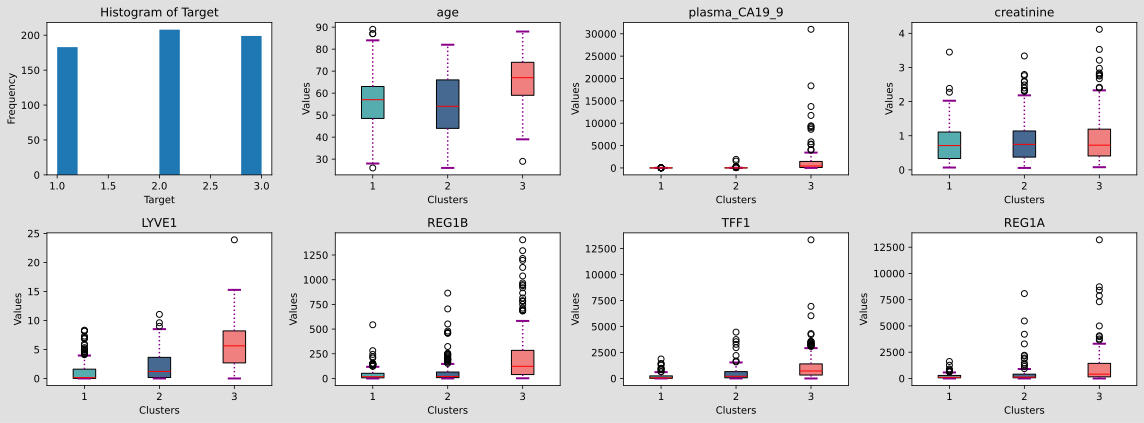

In [9]:
df=df_ini.copy()
xg=4
yg=2

fig, axes = plt.subplots(yg, xg, figsize=(16, 6))

y=df['diagnosis']
fv_hist(y,'Target',axes[0,0])

list_labels=['age','plasma_CA19_9',	'creatinine',	'LYVE1',	'REG1B',	'TFF1',	'REG1A']

count=1
for label in list_labels:
    i=np.floor(count/xg).astype(int)
    j=count%xg
    fv_box(df,label,colors,i,j)
    count+=1

plt.tight_layout()
plt.show()

## 1.4. Be aware of Null values
Maybe drop if I have a "BIG" % of null. For instance, stage will not be considered as it is not always given and because it exists only for already diagnosed


In [10]:
columns_to_drop = []
for col in headers:
  null_for_column = df_ini[col].isna().sum()
  if (null_for_column != 0):
      null_for_column_per = round(null_for_column/df_ini.shape[0] * 100, 2)
      if (null_for_column_per > 30): # Maybe delete if % is "BIG" ?
        columns_to_drop.append(col)
      print(f'Column {col:13} : {null_for_column:4} null values ({null_for_column_per:5}%)')

Column stage         :  391 null values (66.27%)
Column benign_sample_diagnosis :  382 null values (64.75%)
Column plasma_CA19_9 :  240 null values (40.68%)
Column REG1A         :  284 null values (48.14%)


## 1.5. Conclusion
* Features to use: 	age,	sex,	creatinine,	LYVE1,	REG1B,	TFF1
* Not to use: sample_id,	patient_cohort, benign_sample_diagnosis,
* Excessive missing data, need to be treated as they have a huge influence: plasma_CA19_9, REG1A
* May need further analysis: sample_origin, diagnosis,	stage

# 2. Data Imputation


## 2.1. Correlation
Because we saw that the distribution is different for each group for plasma_CA19_9 and REG1A, and because of the previous quick research, I know I can impute data based on the existing dataset. However, let's make a small test.

In [11]:
df_c=df_ini
list_labels=['diagnosis','age', 'creatinine',	'LYVE1',	'REG1B',	'TFF1', 'REG1A', 'plasma_CA19_9']


labels=list_labels
dic=[]

for i in range (len(labels)):

    vector1=df_c[labels[i]]

    for j in range (len(labels)):
        if i!=j:
            vector2=df_c[labels[j]]
            mask = ~np.isnan(vector1) & ~np.isnan(vector2)
            m_v1 = vector1[mask].astype(float)
            m_v2 = vector2[mask].astype(float)
            corr, pval = spearmanr(m_v1, m_v2)
            dic.append([labels[i],labels[j],corr,pval,len(m_v1)])

df_corr=pd.DataFrame(data=dic, index=None, columns=['i','j','corr','pval','mask'])
df_corr['corr_abs']=np.abs(df_corr['corr'])
df_corr

,i,j,corr,pval,mask,corr_abs
0,diagnosis,age,0.324749,5.881932e-16,590,0.324749
1,diagnosis,creatinine,0.043268,2.940652e-01,590,0.043268
2,diagnosis,LYVE1,0.579338,3.473836e-54,590,0.579338
3,diagnosis,REG1B,0.435578,1.028692e-28,590,0.435578
4,diagnosis,TFF1,0.523284,8.757362e-43,590,0.523284
5,diagnosis,REG1A,0.371802,1.821176e-11,306,0.371802
6,diagnosis,plasma_CA19_9,0.772661,1.159515e-70,350,0.772661
7,age,diagnosis,0.324749,5.881932e-16,590,0.324749
8,age,creatinine,-0.041313,3.164465e-01,590,0.041313
9,age,LYVE1,0.309341,1.503151e-14,590,0.309341


In [12]:
def fv_box2(df,columna,categories,var,colors,i,j):
    #columna: column to analize
    # categories: cat existing in column
    # var: the "title" - analyzing variable

    ax=axes[i,j]

    data_cat=[]
    for cat in categories:
        temp=df[df[columna]==cat][var].dropna()
        data_cat.append(temp)

    # Visualization of toxicity distribution by clusters
    box = ax.boxplot(data_cat, patch_artist=True)

    # Use patch_artist to allow coloring
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # changing color and linewidth of whiskers
    for whisker in box['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")

    # changing color and linewidth of caps
    for cap in box['caps']:
        cap.set(color ='#8B008B',
                linewidth = 2)

    # changing color and linewidth of
    # medians
    for median in box['medians']:
        median.set(color ='red',
                   linewidth = 1)

    ax.set_title(var)
    ax.set_xticklabels(categories,rotation=45)
    ax.set_xlabel('Features')
    ax.set_ylabel('Values')

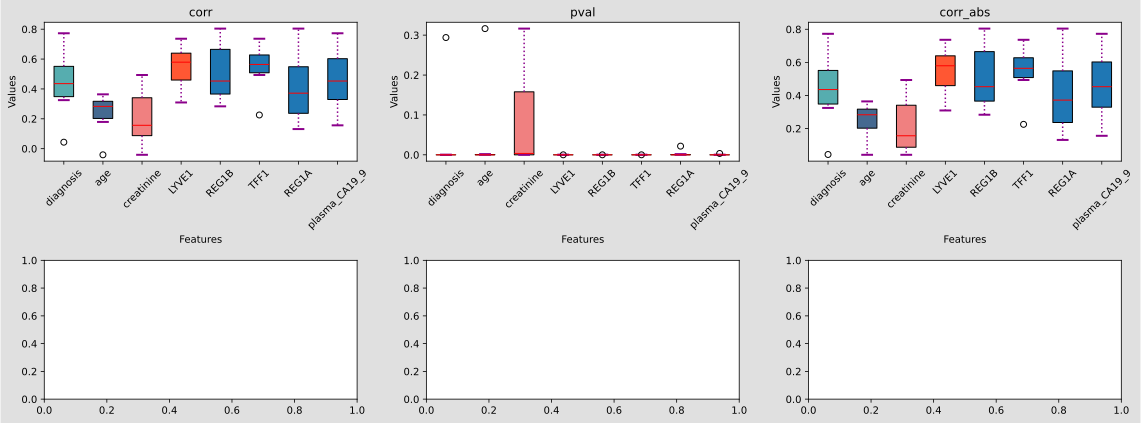

In [13]:
df=df_corr

xg=3
yg=2

fig, axes = plt.subplots(yg, xg, figsize=(16, 6))

count=0

columna='i'
categories=list_labels
variables=['corr',	'pval',	'corr_abs']

for var in variables:
    i=np.floor(count/xg).astype(int)
    j=count%xg
    fv_box2(df,columna,categories,var,colors,i,j) #df,columna,categories,label,colors,i,j
    count+=1

plt.tight_layout()
plt.show()

## Conclusion:
We should use this variables, if we have more time, we can make a more exhaustive analysis, for now let's assume we can

## 2.2. Null distribution
Just before accepting to fill missing values, let's check missing values distribution

In [14]:
df_des['Null1%'] = df_des['Variable'].apply(lambda label: int(df_ini[label][df_ini['diagnosis']==1].isnull().mean() * 100))
df_des['Null2%'] = df_des['Variable'].apply(lambda label: int(df_ini[label][df_ini['diagnosis']==2].isnull().mean() * 100))
df_des['Null3%'] = df_des['Variable'].apply(lambda label: int(df_ini[label][df_ini['diagnosis']==3].isnull().mean() * 100))

df_des

,Variable,Data Type,Unique,Examples,Min,Max,Avg,Std,Null%,Null1%,Null2%,Null3%
0,sample_id,object,590,"[S1, S10, S100]",NaN,NaN,NaN,NaN,0,0,0,0
1,patient_cohort,object,2,"[Cohort1, Cohort2]",NaN,NaN,NaN,NaN,0,0,0,0
2,sample_origin,object,4,"[BPTB, LIV, ESP]",NaN,NaN,NaN,NaN,0,0,0,0
3,age,int64,63,"[33, 81, 51]",26.000000,89.000000,59.079661,13.109520,0,0,0,0
4,sex,object,2,"[F, M]",NaN,NaN,NaN,NaN,0,0,0,0
5,diagnosis,int64,3,"[1, 2, 3]",1.000000,3.000000,2.027119,0.804873,0,0,0,0
6,stage,object,8,"[nan, I, IA]",NaN,NaN,NaN,NaN,66,100,100,0
7,benign_sample_diagnosis,object,47,"[nan, Abdominal Pain, Biliary Stricture (Secon...",NaN,NaN,NaN,NaN,64,100,0,100
8,plasma_CA19_9,float64,266,"[11.7, nan, 7.0]",0.000000,31000.000000,654.002944,2430.317642,40,49,48,24
9,creatinine,float64,198,"[1.83222, 0.97266, 0.78039]",0.056550,4.116840,0.855383,0.639028,0,0,0,0


## 2.3. Data Imputation

In [15]:
def f_imputation(df):

    list_missing=[ 'REG1A', 'plasma_CA19_9']
    list_classes=[1,2,3]

    # We get the category of each empty label in order to fill data
    label_c='diagnosis'
    for label in list_classes:
        class_df=df[df[label_c]==label]
        for feat in list_missing :
            nulls = class_df[class_df[feat].isnull()].index.tolist()
            if len(nulls)>0:
                posib=list(class_df[feat].dropna())
                random.seed(0)
                ops=random.choices(posib, k=len(nulls))
                df.loc[nulls,feat]=ops
    return df

# Code

df=df_ini.copy()
df_completed=f_imputation(df)
df_completed

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.70,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,7.57,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.00,0.78039,0.145589,102.366000,461.141000,169.071
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.00,0.70122,0.002805,60.579000,142.950000,80.386
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.00,0.21489,0.000860,65.540000,41.088000,81.610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,1555.00,0.52026,7.058209,156.241000,525.178000,369.344
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,66.00,0.85956,8.341207,16.915000,245.947000,27.737
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,1621.00,1.36851,7.674707,289.701000,537.286000,30.435
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,91.00,1.33458,8.206777,205.930000,722.523000,521.851


## 2.4. Transform outliers & Normalize

In [16]:
def find_outliers_zscore(data_xi, threshold=3):
    values = np.array(data_xi)
    z_scores = zscore(data_xi)
    no_outliers = values[np.abs(z_scores) <= threshold]
    mini = no_outliers.min()
    maxi = no_outliers.max()

    fixed_values = np.where(z_scores > threshold, maxi,
                             np.where(z_scores < -threshold, mini, values))
    fixed_values2 = (fixed_values - fixed_values.min()) / (fixed_values.max() - fixed_values.min())



    l_outliers = values[np.abs(z_scores) > threshold].tolist()
    l_outliers.sort()
    l_no_outliers = no_outliers.tolist()
    l_no_outliers.sort()
    return l_outliers, l_no_outliers, fixed_values2

df_fixed=df_ini[['diagnosis','sex']]
list_feat=['age','plasma_CA19_9','creatinine','LYVE1','REG1A','REG1B','TFF1']

# Code

df=df_completed

for i in list_feat:
    data_xi=df[i]
    list_out=[]
    outliers, no_outliers,fixed_values = find_outliers_zscore(data_xi)
    df_fixed[i]=fixed_values
    list_out.append(outliers)
df_fixed

/var/folders/8x/1_x46j1s3pb5vsqk90bdlh5m0000gn/T/ipykernel_79198/250774587.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fixed[i]=fixed_values
/var/folders/8x/1_x46j1s3pb5vsqk90bdlh5m0000gn/T/ipykernel_79198/250774587.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fixed[i]=fixed_values
/var/folders/8x/1_x46j1s3pb5vsqk90bdlh5m0000gn/T/ipykernel_79198/250774587.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,diagnosis,sex,age,plasma_CA19_9,creatinine,LYVE1,REG1A,REG1B,TFF1
0,1,F,0.111111,0.001998,0.656904,0.067635,0.299691,0.075996,0.183224
1,1,F,0.873016,0.001293,0.338912,0.154300,0.054241,0.135588,0.058664
2,1,M,0.396825,0.001196,0.267782,0.011016,0.040150,0.146925,0.129137
3,1,M,0.555556,0.001366,0.238494,0.000203,0.019090,0.086948,0.040030
4,1,M,0.571429,0.001537,0.058577,0.000055,0.019380,0.094068,0.011505
...,...,...,...,...,...,...,...,...,...
585,3,M,0.666667,0.265585,0.171548,0.534519,0.087709,0.224252,0.147070
586,3,F,0.714286,0.011272,0.297071,0.631683,0.006587,0.024277,0.068874
587,3,M,0.587302,0.276857,0.485356,0.581207,0.007227,0.415808,0.150460
588,3,F,0.777778,0.015542,0.472803,0.621502,0.123926,0.295571,0.202334


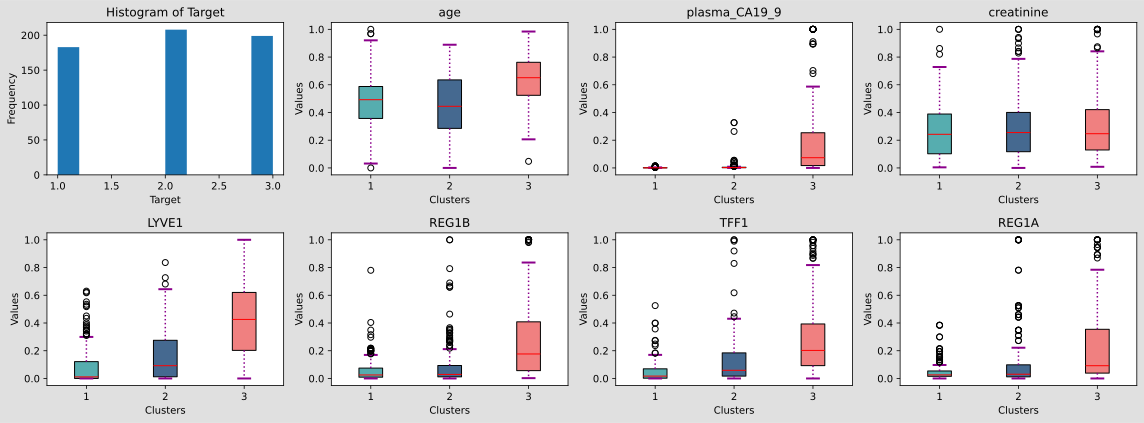

In [17]:
df=df_fixed

xg=4
yg=2

fig, axes = plt.subplots(yg, xg, figsize=(16, 6))

y=df['diagnosis']
fv_hist(y,'Target',axes[0,0])

list_labels=['age','plasma_CA19_9',	'creatinine',	'LYVE1',	'REG1B',	'TFF1',	'REG1A']

count=1
for label in list_labels:
    i=np.floor(count/xg).astype(int)
    j=count%xg
    fv_box(df,label,colors,i,j)
    count+=1

plt.tight_layout()
plt.show()

In [18]:
df_des=f_descriptive(df_fixed)
df_des

,Variable,Data Type,Unique,Examples,Min,Max,Avg,Std,Null%
0,diagnosis,int64,3,"[1, 2, 3]",1.0,3.0,2.027119,0.804873,0
1,sex,object,2,"[F, M]",NaN,NaN,NaN,NaN,0
2,age,float64,63,"[0.1111111111111111, 0.873015873015873, 0.3968...",0.0,1.0,0.525074,0.208088,0
3,plasma_CA19_9,float64,258,"[0.0019982920580700254, 0.0012929120409906063,...",0.0,1.0,0.068543,0.184107,0
4,creatinine,float64,188,"[0.6569037656903766, 0.3389121338912134, 0.267...",0.0,1.0,0.292874,0.226548,0
5,LYVE1,float64,531,"[0.06763505063016365, 0.15429961831682268, 0.0...",0.0,1.0,0.230211,0.252809,0
6,REG1A,float64,290,"[0.2996912847304678, 0.054240560436950844, 0.0...",0.0,1.0,0.138148,0.227890,0
7,REG1B,float64,562,"[0.07599625579222509, 0.13558760474844392, 0.1...",0.0,1.0,0.148787,0.229381,0
8,TFF1,float64,553,"[0.18322414583938904, 0.05866375072829392, 0.1...",0.0,1.0,0.158847,0.224530,0


## 3. Transform categorical data

Transform strings to categories

In [19]:
df=df_fixed

# Categorical
categorical_columns = []
for col in df.columns:
  if df[col].nunique() > 1 and df[col].nunique() <10:
    categorical_columns.append(col)
    print (f'{col} - {df[col].nunique()} values : {df[col].unique()}')

## Convert categories to int
def f_to_cat(df,categorical_columns):
    dic_cat = {}
    for feat in categorical_columns:
        if (df[feat]).dtype == "object":
            df[feat] = df[feat].astype('category')
            dic_cat[feat] = dict(enumerate(df[feat].cat.categories))
            df[feat] = df[feat].cat.codes
    return df
df_cat=f_to_cat(df,categorical_columns)
df_cat

f_descriptive(df_cat)

diagnosis - 3 values : [1 2 3]
sex - 2 values : ['F' 'M']


/var/folders/8x/1_x46j1s3pb5vsqk90bdlh5m0000gn/T/ipykernel_79198/1828286972.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feat] = df[feat].astype('category')
/var/folders/8x/1_x46j1s3pb5vsqk90bdlh5m0000gn/T/ipykernel_79198/1828286972.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feat] = df[feat].cat.codes


,Variable,Data Type,Unique,Examples,Min,Max,Avg,Std,Null%
0,diagnosis,int64,3,"[1, 2, 3]",1.0,3.0,2.027119,0.804873,0
1,sex,int8,2,"[0, 1]",0.0,1.0,0.493220,0.500378,0
2,age,float64,63,"[0.1111111111111111, 0.873015873015873, 0.3968...",0.0,1.0,0.525074,0.208088,0
3,plasma_CA19_9,float64,258,"[0.0019982920580700254, 0.0012929120409906063,...",0.0,1.0,0.068543,0.184107,0
4,creatinine,float64,188,"[0.6569037656903766, 0.3389121338912134, 0.267...",0.0,1.0,0.292874,0.226548,0
5,LYVE1,float64,531,"[0.06763505063016365, 0.15429961831682268, 0.0...",0.0,1.0,0.230211,0.252809,0
6,REG1A,float64,290,"[0.2996912847304678, 0.054240560436950844, 0.0...",0.0,1.0,0.138148,0.227890,0
7,REG1B,float64,562,"[0.07599625579222509, 0.13558760474844392, 0.1...",0.0,1.0,0.148787,0.229381,0
8,TFF1,float64,553,"[0.18322414583938904, 0.05866375072829392, 0.1...",0.0,1.0,0.158847,0.224530,0


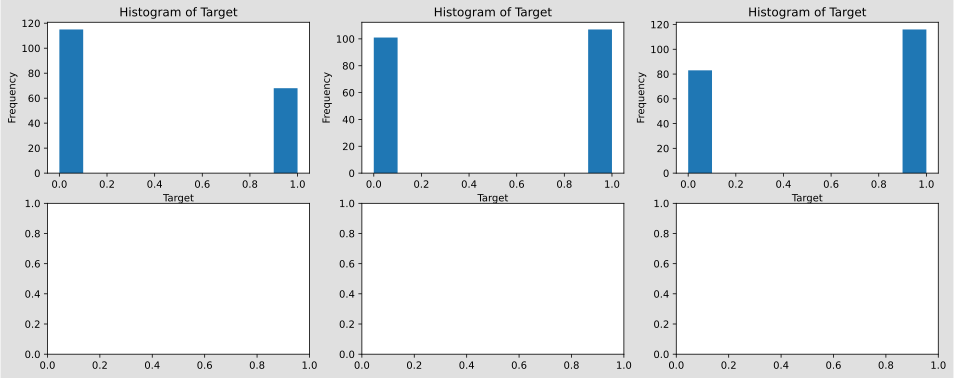

In [20]:
# Code

df=df_cat

xg=3
yg=2

fig, axes = plt.subplots(yg, xg, figsize=(16, 6))

y=df.loc[df['diagnosis'] == 1, 'sex']
fv_hist(y,'Target',axes[0,0])

y=df.loc[df['diagnosis'] == 2, 'sex']
fv_hist(y,'Target',axes[0,1])

y=df.loc[df['diagnosis'] == 3, 'sex']
fv_hist(y,'Target',axes[0,2])

# 4. Graphs

In [21]:
def f_discrete(df):
    # List of columns to be discretized
    no_discrete = ['age', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A', 'plasma_CA19_9']

    # Already discrete
    df_discrete = df[['diagnosis', 'sex']].copy()

    # Transform to discrete
    for col in no_discrete:
        bins = np.linspace(df[col].min(), df[col].max(), 5)  # Create 5 equally spaced bins
        discretized_col = np.digitize(df[col], bins)  # Discretize the column
        df_discrete[col] = discretized_col  # Add the discretized column to the DataFrame

    # Final dataframe with discretized and original categorical data
    return df_discrete

df_discrete=f_discrete(df_cat)
df_discrete

,diagnosis,sex,age,creatinine,LYVE1,REG1B,TFF1,REG1A,plasma_CA19_9
0,1,0,1,3,1,1,1,2,1
1,1,0,4,2,1,1,1,1,1
2,1,1,2,2,1,1,1,1,1
3,1,1,3,1,1,1,1,1,1
4,1,1,3,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
585,3,1,3,1,3,1,1,1,2
586,3,0,3,2,3,1,1,1,1
587,3,1,3,2,3,2,1,1,2
588,3,0,4,2,3,2,1,1,1


In [22]:
selected_cols=['diagnosis', 'age', 'REG1A', 'plasma_CA19_9',  'LYVE1', 'REG1B']

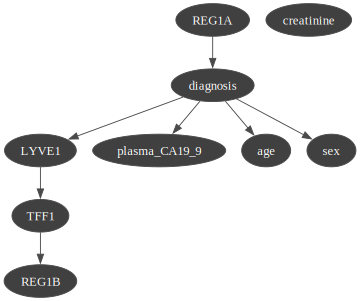

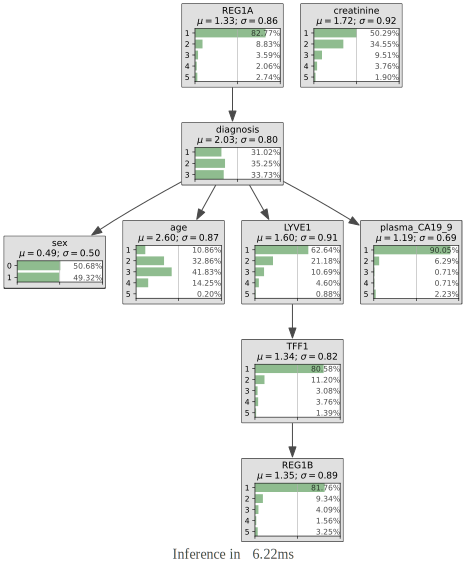

In [23]:
df= df_discrete
# 1. Local Search with Tabu List
learner = gum.BNLearner(df)  # Creating a BNLearner from the DataFrame
learner.useLocalSearchWithTabuList()  # Use local search with tabu list
bn = learner.learnBN()  # Learn the Bayesian Network

# Display the learned Bayesian Network
gnb.showBN(bn)  # To show the network in Jupyter
gnb.showInference(bn,evs={},size="100")

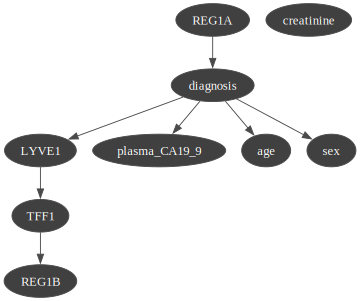

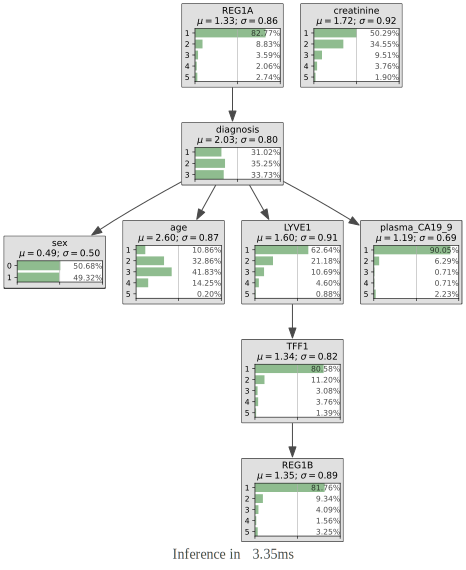

In [24]:
# 2. Greedy Hill Climbing
learner = gum.BNLearner(df)  # Reinitialize the learner
learner.useGreedyHillClimbing()  # Use greedy hill climbing method
bn = learner.learnBN()  # Learn the Bayesian Network

# Display the learned Bayesian Network (Greedy Hill Climbing)
gnb.showBN(bn)
gnb.showInference(bn,evs={},size="100")

# * Pause: Existing Datasets

In [25]:
# This Dataset contains Normalized data, without outliers
df_cat.head()

,diagnosis,sex,age,plasma_CA19_9,creatinine,LYVE1,REG1A,REG1B,TFF1
0,1,0,0.111111,0.001998,0.656904,0.067635,0.299691,0.075996,0.183224
1,1,0,0.873016,0.001293,0.338912,0.154300,0.054241,0.135588,0.058664
2,1,1,0.396825,0.001196,0.267782,0.011016,0.040150,0.146925,0.129137
3,1,1,0.555556,0.001366,0.238494,0.000203,0.019090,0.086948,0.040030
4,1,1,0.571429,0.001537,0.058577,0.000055,0.019380,0.094068,0.011505


In [26]:
# This Dataset contains Normalized data, without outliers, and is discrete
df_discrete.head()

,diagnosis,sex,age,creatinine,LYVE1,REG1B,TFF1,REG1A,plasma_CA19_9
0,1,0,1,3,1,1,1,2,1
1,1,0,4,2,1,1,1,1,1
2,1,1,2,2,1,1,1,1,1
3,1,1,3,1,1,1,1,1,1
4,1,1,3,1,1,1,1,1,1


In [27]:
# This Dataset  contains Normalized data, without outliers, and only complete columns
df_cat_complete=df_cat.drop(columns=['REG1A', 'plasma_CA19_9'])
df_cat_complete.head()

,diagnosis,sex,age,creatinine,LYVE1,REG1B,TFF1
0,1,0,0.111111,0.656904,0.067635,0.075996,0.183224
1,1,0,0.873016,0.338912,0.154300,0.135588,0.058664
2,1,1,0.396825,0.267782,0.011016,0.146925,0.129137
3,1,1,0.555556,0.238494,0.000203,0.086948,0.040030
4,1,1,0.571429,0.058577,0.000055,0.094068,0.011505


In [28]:
# This Dataset  contains Normalized data, without outliers, and only selected columns
df_feat_cat=df_cat.copy()
df_feat_cat=df_feat_cat[['diagnosis','age','sex','REG1B', 'plasma_CA19_9','TFF1']]
df_feat_cat.head()

,diagnosis,age,sex,REG1B,plasma_CA19_9,TFF1
0,1,0.111111,0,0.075996,0.001998,0.183224
1,1,0.873016,0,0.135588,0.001293,0.058664
2,1,0.396825,1,0.146925,0.001196,0.129137
3,1,0.555556,1,0.086948,0.001366,0.040030
4,1,0.571429,1,0.094068,0.001537,0.011505


In [29]:
# This Dataset  contains Normalized data, without outliers, and only selected columns
df_feat_discrete=df_discrete.copy()
df_feat_discrete=df_feat_discrete[['diagnosis','age','sex','REG1B', 'plasma_CA19_9','TFF1']]
df_feat_discrete.head()

,diagnosis,age,sex,REG1B,plasma_CA19_9,TFF1
0,1,1,0,1,1,1
1,1,4,0,1,1,1
2,1,2,1,1,1,1
3,1,3,1,1,1,1
4,1,3,1,1,1,1


In [30]:
# This dataset is Binary, may help into the separation of variables
# Separates into
df_bin=df_cat.copy()
df_bin['diagnosis'] = df_bin['diagnosis'].replace({2: 1, 3: 2})
df_bin.head()

,diagnosis,sex,age,plasma_CA19_9,creatinine,LYVE1,REG1A,REG1B,TFF1
0,1,0,0.111111,0.001998,0.656904,0.067635,0.299691,0.075996,0.183224
1,1,0,0.873016,0.001293,0.338912,0.154300,0.054241,0.135588,0.058664
2,1,1,0.396825,0.001196,0.267782,0.011016,0.040150,0.146925,0.129137
3,1,1,0.555556,0.001366,0.238494,0.000203,0.019090,0.086948,0.040030
4,1,1,0.571429,0.001537,0.058577,0.000055,0.019380,0.094068,0.011505


## 5. Classification

In [31]:
def f_classsification(X,Y):
    n_clusters=3

    list_pred=[]
    model="kmeans"
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1, random_state=42).fit(X,Y)
    y_pred=km.labels_
    list_pred.append([model,y_pred])

    model='H average'
    clustering = AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
    clustering.fit(X)
    y_pred=clustering.labels_
    list_pred.append([model,y_pred])

    model='Spectral'
    spectral = cluster.SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack',
    affinity="nearest_neighbors")
    spectral.fit(X)
    y_pred=spectral.labels_
    list_pred.append([model,y_pred])

    return list_pred,km,clustering,spectral

### 5.1. Evaluation
*   **Homogeneity_score**, in the context of clustering, refers to the idea that each cluster contains only members of a single class.

*   **Completeness_score** measures how well each class is captured by a single cluster, avoiding splitting a class across multiple clusters.

*   **v_measure_score** combines both homogeneity and completeness to provide a balanced measure of clustering performance.

*   **adjusted_rand_score** evaluate the similarity between the true class labels and the predicted cluster labels, adjusted for chance. It measures the agreement between the true and predicted labels while accounting for randomness.


In [32]:
def f_score_c(Y,list_pred):
    list_model=[]
    list_homogeneity=[]
    list_completeness=[]
    list_vmeasure=[]
    list_randscore=[]
    list_recall_prec=[]
    for i in range(len(list_pred)):
      y_real = Y

      model, y_pred = list_pred[i]
      list_model.append(model)
      list_homogeneity.append(metrics.homogeneity_score(y_real, y_pred))
      list_completeness.append(metrics.completeness_score(y_real, y_pred))
      list_vmeasure.append(metrics.v_measure_score(y_real, y_pred))
      list_randscore.append(metrics.adjusted_rand_score(y_real, y_pred))
      list_recall_prec.append(metrics.fowlkes_mallows_score(y_real, y_pred))

    df = pd.DataFrame({'Homogeneity':list_homogeneity,'Completeness':list_completeness,'V_Measure':list_vmeasure,'Rand_Score':list_randscore,'Recall_Precision':list_recall_prec},index=list_model)
    return df

## Testing with complete data

In [33]:
# Code
df_testing=df_cat

X=df_testing.drop(columns=['diagnosis'])
Y=df_testing['diagnosis']

list_pred,km,clustering,spectral = f_classsification(X,Y)

## Explaining why

In [34]:
x_test=[X.iloc[0].values]
km.predict(x_test)
centroids = km.cluster_centers_
distances = np.linalg.norm(centroids - x_test, axis=1)
features=X.columns
list_distances=abs(centroids-x_test)
#print('Centroids: ',centroids)
#for i, distance in enumerate(distances):
#    print('Distance: ', distance)

# Explaining why
i_closest = np.argmin(distances)
closest=centroids[i_closest]
sorted_features = [feature for value, feature in sorted(zip(list_distances[i_closest], features))]
print(' The result was given according: ',sorted_features)

 The result was given according:  ['sex', 'REG1B', 'plasma_CA19_9', 'LYVE1', 'TFF1', 'REG1A', 'age', 'creatinine']


/Users/bren/fun/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


## Testing performance

In [35]:
# Testing with completed dataset
list_pred_c,_,_,_=f_classsification(X,Y)
df_score_c=f_score_c(Y,list_pred_c)
df_score_c

,Homogeneity,Completeness,V_Measure,Rand_Score,Recall_Precision
kmeans,0.076558,0.086636,0.081286,0.039996,0.393010
H average,0.026778,0.191839,0.046996,0.002288,0.560124
Spectral,0.082310,0.086490,0.084348,0.061254,0.391219


In [36]:
# Testing with discrete dataset
df_testing=df_discrete
X=df_testing.drop(columns=['diagnosis'])
Y=df_testing['diagnosis']
list_pred_d,_,_,_=f_classsification(X,Y)
df_score_c=f_score_c(Y,list_pred_d)
df_score_c

,Homogeneity,Completeness,V_Measure,Rand_Score,Recall_Precision
kmeans,0.087879,0.113059,0.098891,0.042105,0.434311
H average,0.046525,0.216049,0.076563,0.007909,0.550160
Spectral,0.054836,0.075465,0.063517,0.044940,0.451948


In [37]:
# Testing with selected features
df_testing=df_feat_cat.copy()
X=df_testing.drop(columns=['diagnosis'])
Y=df_testing['diagnosis']
list_pred_g,_,_,_=f_classsification(X,Y)
df_score_c=f_score_c(Y,list_pred_g)
df_score_c

,Homogeneity,Completeness,V_Measure,Rand_Score,Recall_Precision
kmeans,0.092018,0.109524,0.100011,0.061617,0.416256
H average,0.038795,0.053616,0.045017,0.025357,0.413344
Spectral,0.055768,0.059461,0.057556,0.037320,0.379132


In [38]:

# Testing with completed dataset, binary
df_testing=df_feat_discrete
X=df_testing.drop(columns=['diagnosis'])
Y=df_testing['diagnosis']
list_pred_d,_,_,_=f_classsification(X,Y)
df_score_c=f_score_c(Y,list_pred_d)
df_score_c

,Homogeneity,Completeness,V_Measure,Rand_Score,Recall_Precision
kmeans,0.107181,0.12605,0.115852,0.074436,0.422237
H average,0.028431,0.13932,0.047225,0.003450,0.550334
Spectral,0.081622,0.11160,0.094286,0.091306,0.459900


In [39]:
# Testing with completed dataset, binary
df_testing=df_bin
X=df_testing.drop(columns=['diagnosis'])
Y=df_testing['diagnosis']
list_pred_d,_,_,_=f_classsification(X,Y)
df_score_c=f_score_c(Y,list_pred_d)
df_score_c

,Homogeneity,Completeness,V_Measure,Rand_Score,Recall_Precision
kmeans,0.116947,0.077100,0.092932,0.095856,0.524820
H average,0.044288,0.184842,0.071455,0.059016,0.738083
Spectral,0.129706,0.079402,0.098503,0.046120,0.478597


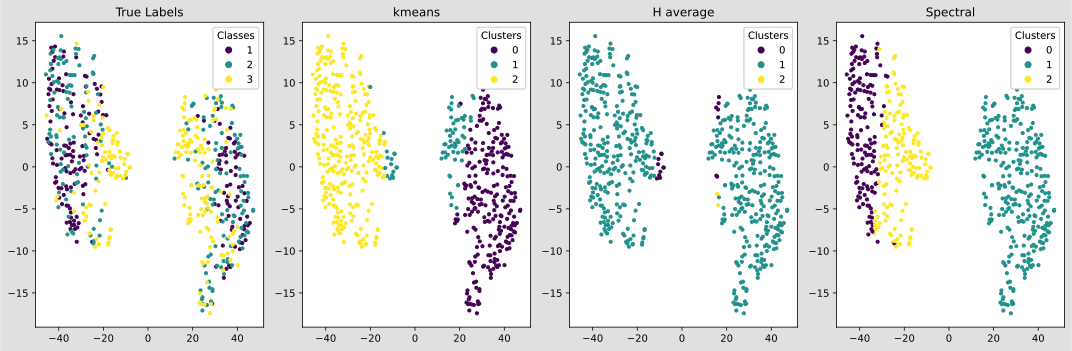

In [40]:
def fv_clusters(X, Y, list_pred):
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_reduced = tsne.fit_transform(X)

    # Create subplots for each clustering model
    fig, axs = plt.subplots(1, len(list_pred) + 1, figsize=(15, 5))

    # Plot true labels
    scatter = axs[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap='viridis', s=10)
    axs[0].set_title('True Labels')
    legend1 = axs[0].legend(*scatter.legend_elements(), title="Classes")
    axs[0].add_artist(legend1)

    # Plot clusters for each model
    for i, (model, y_pred) in enumerate(list_pred):
        scatter = axs[i + 1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='viridis', s=10)
        axs[i + 1].set_title(model)
        legend = axs[i + 1].legend(*scatter.legend_elements(), title="Clusters")
        axs[i + 1].add_artist(legend)

    plt.tight_layout()
    plt.show()


# Code
df_testing=df_cat

X=df_testing.drop(columns=['diagnosis'])
Y=df_testing['diagnosis']

# Visualize using t-SNE
fv_clusters(X, Y, list_pred_c)


## Conclusion:
* The proposed methodologies may not be suitable for this dataset, maybe we need to add different weights to each feature

# 6. Regressions!

## Testing with normalized dataset

In [41]:
# Code
df=df_cat

X=df.drop(columns=['diagnosis'])
Y=df['diagnosis']

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Logistic regression model - for classes
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

# Predictions
Y_pred = model.predict(X_test)

# Evaluation
print(classification_report(Y_test, Y_pred))


              precision    recall  f1-score   support

           1       0.68      0.61      0.64        41
           2       0.51      0.46      0.49        39
           3       0.72      0.87      0.79        38

    accuracy                           0.64       118
   macro avg       0.64      0.65      0.64       118
weighted avg       0.64      0.64      0.64       118



## Testing with feautured

In [42]:
# Code
df=df_feat_cat

X=df.drop(columns=['diagnosis'])
Y=df['diagnosis']

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Logistic regression model - for classes
model = LogisticRegression(max_iter=200)
model.fit(X_train, Y_train)

# Predictions
Y_pred = model.predict(X_test)

# Evaluation
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.68      0.63      0.66        41
           2       0.58      0.54      0.56        39
           3       0.73      0.84      0.78        38

    accuracy                           0.67       118
   macro avg       0.66      0.67      0.67       118
weighted avg       0.66      0.67      0.67       118



# 7. Desicion Trees

In [43]:
def f_tree(X,Y):

    # Data split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Create a Decision Tree Classifier and train it
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, Y_train)

    # Visualize the decision tree
    plt.figure(figsize=(12,8))
    plot_tree(clf, feature_names=X.columns, class_names=['1','2','3'], filled=True)
    plt.show()

    export_graphviz(clf, out_file=path+'tree.dot', feature_names=X.columns, class_names=['Healthy', 'Non-cancerous pancreatic conditions', 'Adenocarcinoma'], filled=True)
    with open('tree.dot') as f:
        dot_graph = f.read()
    graphviz.Source(dot_graph).render(path+'decision_tree', format='png', cleanup=True)




    # Calculate metrics
    accuracy = accuracy_score(Y_test, Y_pred)
    conf_matrix = confusion_matrix(Y_test, Y_pred)
    class_report = classification_report(Y_test, Y_pred)

    # Print the metrics
    print("Accuracy:", accuracy)
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", class_report)
    return X_test, clf

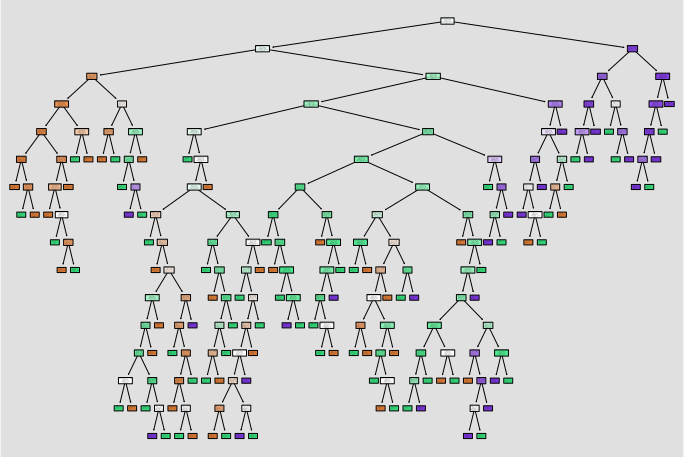

Accuracy: 0.6694915254237288

Confusion Matrix:
 [[26 12  3]
 [ 9 21  9]
 [ 3  3 32]]

Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.63      0.66        41
           2       0.58      0.54      0.56        39
           3       0.73      0.84      0.78        38

    accuracy                           0.67       118
   macro avg       0.66      0.67      0.67       118
weighted avg       0.66      0.67      0.67       118



In [44]:
# Code for "normal" dataset
df=df_cat.copy()
X_keep=df.drop(columns=['diagnosis'])
Y_keep=df['diagnosis']
X_test_keep, clf_keep=f_tree(X,Y)


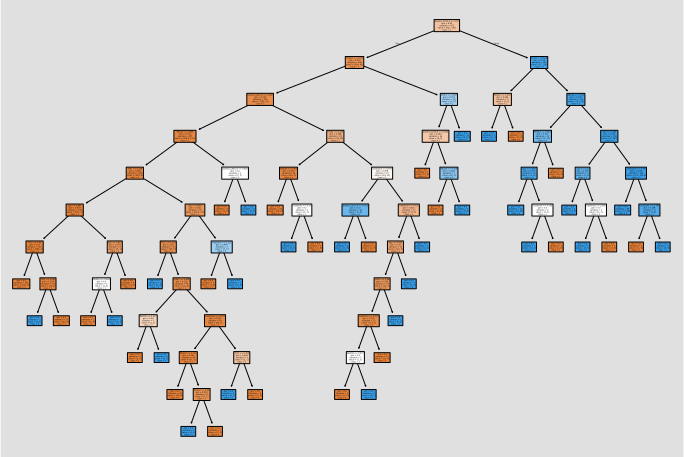

Accuracy: 0.3220338983050847

Confusion Matrix:
 [[35 33 12]
 [ 3  3 32]
 [ 0  0  0]]

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.44      0.59        80
           2       0.08      0.08      0.08        38
           3       0.00      0.00      0.00         0

    accuracy                           0.32       118
   macro avg       0.33      0.17      0.22       118
weighted avg       0.65      0.32      0.43       118



/Users/bren/fun/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bren/fun/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bren/fun/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# Code for binary Dataset
df=df_bin.copy()
X=df.drop(columns=['diagnosis'])
Y=df['diagnosis']
X_test, clf=f_tree(X,Y)

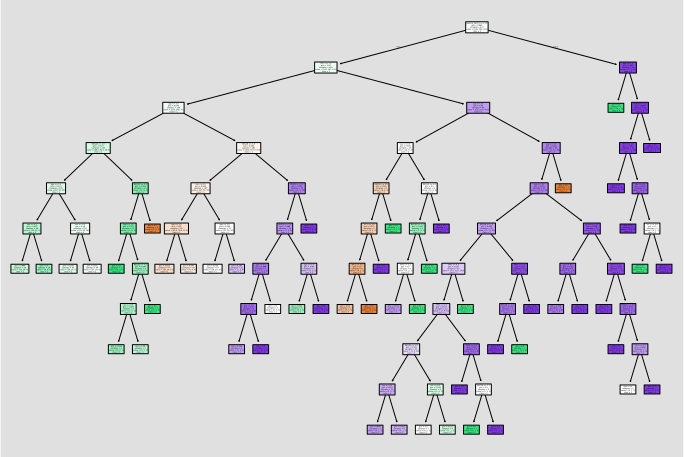

Accuracy: 0.6694915254237288

Confusion Matrix:
 [[26 12  3]
 [ 9 21  9]
 [ 3  3 32]]

Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.63      0.66        41
           2       0.58      0.54      0.56        39
           3       0.73      0.84      0.78        38

    accuracy                           0.67       118
   macro avg       0.66      0.67      0.67       118
weighted avg       0.66      0.67      0.67       118



In [46]:
# Code dor discrete dataset
df=df_feat_discrete.copy()
X=df.drop(columns=['diagnosis'])
Y=df['diagnosis']
X_test, clf=f_tree(X,Y)

### Explanation why

In [47]:
X=X_keep
Y=Y_keep
X_test=X_test_keep
clf=clf_keep

x_test=[X_test.iloc[0]]


# Decision path
node_indicator = clf.decision_path(x_test)
# Features & threshold values
feature = clf.tree_.feature
threshold = clf.tree_.threshold
list_features=[]
print(f"Decision path :")
for node_id in node_indicator.indices:
    if feature[node_id] != -2:  # Check if the node is not a leaf
        threshold_value = threshold[node_id]
        feature_name = X.columns[feature[node_id]]
        list_features.append(feature_name)
        print(f"Node {node_id}: {feature_name} <= {threshold_value:.4f}")
    else:
        print(f"Node {node_id} is a leaf node.")

# Final classification
prediction = clf.predict(x_test)
print(f"Predicted class: {prediction[0]}")
print('Based on: ', set(list_features))


Decision path :
Node 0: creatinine <= 0.0202
Node 192: plasma_CA19_9 <= 0.0318
Node 204: creatinine <= 0.0556
Node 212 is a leaf node.
Predicted class: 3
Based on:  {'creatinine', 'plasma_CA19_9'}


/Users/bren/fun/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/bren/fun/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


# Conclusions & Perspective
* The best performance was obtained after using the dataset without outliers, normalized, with selected features.
* Features were selected by: Target distribution, correlation for "diagnosis", graph, and the preference of REG1B over REG1A because of missing data. Features chosen: ['diagnosis' , 'age' , 'sex' , 'REG1B' , 'plasma_CA19_9' , 'TFF1']
* For now, we can say that the best model was a decision tree as it performs better and is easily interpretable


In order to improve the model we can:
* discretice data according to scientific papers
* test different outliers
* classify separately and then using a "1 vs all" to select the class (for example for k-means) to use more variables


To present the results:
* We can use the output of decisiont tree and reescale so we can explain the parameters that made the model chose one category (be aware if we keep continuous or discrete data)

In [48]:
!pip freeze -> requirements.txt